# Pull Request Analysis

## Visualization Limitations and Alternatives

**Visualization Limitations for Reporting on Several Repos**

The visualizations in this notebook are, like most, able to coherently display information for between 1 and 8 different repositories simultaneously. 

**Alternatives for Reporting on Repo Groups, Comprising Many Repos**

The included queries could be rewritten to show an entire repository group's characteristics of that is your primary aim. Specifically, any query could replace this line: 
```
                            WHERE repo.repo_id = {repo_id}
```

with this line to accomplish the goal of comparing different groups of repositories: 
```
                            WHERE repogroups.repo_group_id = {repo_id}
```

Simply replace the set of id's in the **Pull Request Filter** section with a list of repo_group_id numbers as well, to accomplish this view. 

------------
All the notebooks in this folder are based on https://github.com/chaoss/augur-community-reports templates. 

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("../../config_temp.json") as config_file:
    config = json.load(config_file) 

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

## Control Cells - Set Variables and Filters 

The cell below is for generating repo_ids from the repo names. For this to work, the repo must already be in the database. If you want to manually assign a repo_id skip the cell below and read the comments on the next cell.

In [3]:
#add your repo name here of the repo you want to query if known (and in the database)
repo_name_set = ['augur', 'grimoirelab']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440, 25448]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number
#repo_set = {25440, 25448}

#can be set as 'competitors' or 'repo'
#'competitors' will group graphs by type, so it is easy to compare across repos
# 'repo' will group graphs by repo so it is easy to look at all the contributor data for each repo
display_grouping = 'repo'

#if display_grouping is set to 'competitors', enter the repo ids you do no want to alias, if 'display_grouping' is set to repo the list will not effect anything
not_aliased_repos = [25440, 25448]

begin_date = '2019-6-01'
end_date = '2020-6-30'

#specify number of outliers for removal in scatter plot
scatter_plot_outliers_removed = 5
save_files = False

## Longest Running Pull Requests Data Acccessing and Processing

### Query

In [5]:
pr_all = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                    SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        pr_src_author_association,
                        repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_merged_at,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
                        date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        pr_src_meta_label,
                        pr_head_or_base,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
                        first_response_time,
                        last_response_time,
                        average_time_between_responses,
                        assigned_count,
                        review_requested_count,
                        labeled_count,
                        subscribed_count,
                        mentioned_count,
                        referenced_count,
                        closed_count,
                        head_ref_force_pushed_count,
                        merged_count,
                        milestoned_count,
                        unlabeled_count,
                        head_ref_deleted_count,
                        comment_count,
                        lines_added, 
                        lines_removed,
                        commit_count, 
                        file_count
                    FROM
                        repo,
                        repo_groups,
                        pull_requests LEFT OUTER JOIN ( 
                            SELECT pull_requests.pull_request_id,
                            count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                            count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                            count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                            count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                            count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                            count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                            count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                            count(*) FILTER (WHERE action = 'closed') AS closed_count,
                            count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                            count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                            count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                            count(*) FILTER (WHERE action = 'merged') AS merged_count,
                            MIN(message.msg_timestamp) AS first_response_time,
                            COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                            MAX(message.msg_timestamp) AS last_response_time,
                            (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses
                            FROM pull_request_events, pull_requests, repo, pull_request_message_ref, message
                            WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                            AND pull_requests.pull_request_id = pull_request_events.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                            AND pull_request_message_ref.msg_id = message.msg_id
                            GROUP BY pull_requests.pull_request_id
                        ) response_times
                        ON pull_requests.pull_request_id = response_times.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT pull_request_commits.pull_request_id, count(DISTINCT pr_cmt_sha) AS commit_count                                FROM pull_request_commits, pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_cmt_sha <> pull_requests.pr_merge_commit_sha
                            AND pr_cmt_sha <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                        ) all_commit_counts
                        ON pull_requests.pull_request_id = all_commit_counts.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT MAX(pr_repo_meta_id), pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                            FROM pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_head_or_base = 'base'
                            GROUP BY pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                        ) base_labels
                        ON base_labels.pull_request_id = all_commit_counts.pull_request_id
                        LEFT OUTER JOIN (
                            SELECT sum(cmt_added) AS lines_added, sum(cmt_removed) AS lines_removed, pull_request_commits.pull_request_id, count(DISTINCT cmt_filename) AS file_count
                            FROM pull_request_commits, commits, pull_requests, pull_request_meta
                            WHERE cmt_commit_hash = pr_cmt_sha
                            AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND commits.repo_id = pull_requests.repo_id
                            AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                            AND commits.cmt_commit_hash <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                        ) master_merged_counts 
                        ON base_labels.pull_request_id = master_merged_counts.pull_request_id                    
                    WHERE 
                        repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id} 
                    ORDER BY
                       merged_count DESC
        """)
    pr_a = pd.read_sql(pr_query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_a]) 
    else: 
        # first repo
        pr_all = pr_a
display(pr_all.head())
#pr_all.dtypes

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,head_ref_force_pushed_count,merged_count,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count
0,25440,728212464,augur,MEMBER,chaoss,closed,2021-09-06 23:12:48,2021-09-06 23:10:23,2021-09-06 23:12:48,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,97.0,2.0
1,25440,103980067,augur,CONTRIBUTOR,chaoss,closed,2017-01-31 20:09:52,2017-01-31 17:08:16,2017-01-31 20:09:52,2017.0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0
2,25440,548328648,augur,MEMBER,chaoss,closed,2021-01-04 16:06:01,2021-01-04 16:05:36,2021-01-04 16:06:01,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,48818.0,48818.0,3.0,7.0
3,25440,548575200,augur,CONTRIBUTOR,chaoss,closed,2021-01-05 01:40:57,2021-01-05 01:35:16,2021-01-05 01:40:57,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,254950.0,195116.0,225.0,159.0
4,25440,548580208,augur,CONTRIBUTOR,chaoss,closed,2021-01-05 18:07:57,2021-01-05 01:51:46,2021-01-05 18:07:57,2021.0,...,NaN,NaN,NaN,NaN,NaN,NaN,648.0,503.0,1.0,2.0


### Begin data pre-processing and adding columns

**Data type changing**

In [6]:
# change count columns from float datatype to integer
pr_all[['assigned_count',
          'review_requested_count',
          'labeled_count',
          'subscribed_count',
          'mentioned_count',
          'referenced_count',
          'closed_count',
          'head_ref_force_pushed_count',
          'merged_count',
          'milestoned_count',
          'unlabeled_count',
          'head_ref_deleted_count',
          'comment_count',
        'commit_count',
        'file_count',
        'lines_added',
        'lines_removed'
       ]] = pr_all[['assigned_count',
                                      'review_requested_count',
                                      'labeled_count',
                                      'subscribed_count',
                                      'mentioned_count',
                                      'referenced_count',
                                      'closed_count',
                                        'head_ref_force_pushed_count',
                                    'merged_count',
                                      'milestoned_count',          
                                      'unlabeled_count',
                                      'head_ref_deleted_count',
                                      'comment_count',
                                        'commit_count',
                                        'file_count',
                                        'lines_added',
                                        'lines_removed'
                   ]].astype(float)
# Change years to int so that doesn't display as 2019.0 for example
pr_all[[
            'created_year',
           'closed_year']] = pr_all[['created_year',
                                       'closed_year']].fillna(-1).astype(int).astype(str)
#pr_all.dtypes

In [7]:
print(pr_all['repo_name'].unique())

['augur' 'grimoirelab']


**Add `average_days_between_responses` and `average_hours_between_responses` columns**

In [8]:
# Get days for average_time_between_responses time delta

pr_all['average_days_between_responses'] = pr_all['average_time_between_responses'].map(lambda x: x.days).astype(float)
pr_all['average_hours_between_responses'] = pr_all['average_time_between_responses'].map(lambda x: x.days * 24).astype(float)

pr_all.head()

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses
0,25440,728212464,augur,MEMBER,chaoss,closed,2021-09-06 23:12:48,2021-09-06 23:10:23,2021-09-06 23:12:48,2021,...,NaN,NaN,NaN,NaN,2.0,2.0,97.0,2.0,NaN,NaN
1,25440,103980067,augur,CONTRIBUTOR,chaoss,closed,2017-01-31 20:09:52,2017-01-31 17:08:16,2017-01-31 20:09:52,2017,...,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,NaN,NaN
2,25440,548328648,augur,MEMBER,chaoss,closed,2021-01-04 16:06:01,2021-01-04 16:05:36,2021-01-04 16:06:01,2021,...,NaN,NaN,NaN,NaN,48818.0,48818.0,3.0,7.0,NaN,NaN
3,25440,548575200,augur,CONTRIBUTOR,chaoss,closed,2021-01-05 01:40:57,2021-01-05 01:35:16,2021-01-05 01:40:57,2021,...,NaN,NaN,NaN,NaN,254950.0,195116.0,225.0,159.0,NaN,NaN
4,25440,548580208,augur,CONTRIBUTOR,chaoss,closed,2021-01-05 18:07:57,2021-01-05 01:51:46,2021-01-05 18:07:57,2021,...,NaN,NaN,NaN,NaN,648.0,503.0,1.0,2.0,NaN,NaN


**Date filtering entire dataframe**

In [9]:
start_date = pd.to_datetime(begin_date)
# end_date = pd.to_datetime('2020-02-01 09:00:00')
end_date = pd.to_datetime(end_date)
pr_all = pr_all[(pr_all['pr_created_at'] > start_date) & (pr_all['pr_closed_at'] < end_date)]

pr_all['created_year'] = pr_all['created_year'].map(int)
pr_all['created_month'] = pr_all['created_month'].map(int)
pr_all['created_month'] = pr_all['created_month'].map(lambda x: '{0:0>2}'.format(x))
pr_all['created_yearmonth'] = pd.to_datetime(pr_all['created_year'].map(str) + '-' + pr_all['created_month'].map(str) + '-01')
pr_all.head(1)

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses,created_yearmonth
325,25440,284365174,augur,CONTRIBUTOR,chaoss,closed,2019-06-02 19:37:27,2019-06-02 19:31:32,2019-06-02 19:37:27,2019,...,NaN,NaN,NaN,6526.0,266.0,20.0,26.0,NaN,NaN,2019-06-01


**add `days_to_close` column for pull requests that are still open (closed pull requests already have this column filled from the query)**

Note: there will be no pull requests that are still open in the dataframe if you filtered by an end date in the above cell

In [10]:
import datetime
# getting the number of days of (today - created at) for the PRs that are still open
# and putting this in the days_to_close column

# get timedeltas of creation time to todays date/time
days_to_close_open_pr = datetime.datetime.now() - pr_all.loc[pr_all['pr_src_state'] == 'open']['pr_created_at']

# get num days from above timedelta
days_to_close_open_pr = days_to_close_open_pr.apply(lambda x: x.days).astype(int)

# for only OPEN pr's, set the days_to_close column equal to above dataframe
pr_all.loc[pr_all['pr_src_state'] == 'open'] = pr_all.loc[pr_all['pr_src_state'] == 'open'].assign(days_to_close=days_to_close_open_pr)

pr_all.loc[pr_all['pr_src_state'] == 'open'].head()

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses,created_yearmonth


**Add `closed_yearmonth` column for only CLOSED pull requests**

In [11]:
# initiate column by setting all null datetimes
pr_all['closed_yearmonth'] = pd.to_datetime(np.nan)

# Fill column with prettified string of year/month closed that looks like: 2019-07-01
pr_all.loc[pr_all['pr_src_state'] == 'closed'] = pr_all.loc[pr_all['pr_src_state'] == 'closed'].assign(
    closed_yearmonth = pd.to_datetime(pr_all.loc[pr_all['pr_src_state'] == 'closed']['closed_year'].astype(int
        ).map(str) + '-' + pr_all.loc[pr_all['pr_src_state'] == 'closed']['closed_month'].astype(int).map(str) + '-01'))

pr_all.loc[pr_all['pr_src_state'] == 'closed']

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses,created_yearmonth,closed_yearmonth
325,25440,284365174,augur,CONTRIBUTOR,chaoss,closed,2019-06-02 19:37:27,2019-06-02 19:31:32,2019-06-02 19:37:27,2019,...,NaN,NaN,6526.0,266.0,20.0,26.0,NaN,NaN,2019-06-01,2019-06-01
326,25440,284982970,augur,MEMBER,chaoss,closed,2019-06-06 13:37:51,2019-06-04 13:48:55,2019-06-06 13:37:51,2019,...,NaN,NaN,844.0,110.0,11.0,3.0,NaN,NaN,2019-06-01,2019-06-01
327,25440,286704474,augur,MEMBER,chaoss,closed,2019-06-10 14:40:42,2019-06-10 14:39:31,2019-06-10 14:40:43,2019,...,NaN,NaN,1022.0,150.0,15.0,4.0,NaN,NaN,2019-06-01,2019-06-01
328,25440,289844300,augur,CONTRIBUTOR,chaoss,closed,2019-06-19 19:55:03,2019-06-19 19:17:42,2019-06-19 19:55:03,2019,...,NaN,NaN,51704.0,50396.0,140.0,265.0,NaN,NaN,2019-06-01,2019-06-01
329,25440,292804650,augur,MEMBER,chaoss,closed,2019-06-28 17:06:17,2019-06-28 12:04:16,2019-06-28 17:06:17,2019,...,NaN,NaN,79.0,130.0,1.0,4.0,NaN,NaN,2019-06-01,2019-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,25448,356138303,grimoirelab,MEMBER,chaoss,closed,NaT,2019-12-23 00:51:55,2020-02-10 16:46:32,2019,...,0.0,1.0,NaN,NaN,1.0,NaN,0.0,0.0,2019-12-01,2020-02-01
174,25448,402822645,grimoirelab,CONTRIBUTOR,chaoss,closed,NaT,2020-04-13 20:22:36,2020-06-03 15:07:12,2020,...,1.0,1.0,NaN,NaN,1.0,NaN,0.0,0.0,2020-04-01,2020-06-01
176,25448,365567113,grimoirelab,NONE,chaoss,closed,NaT,2020-01-21 22:54:11,2020-01-21 23:22:43,2020,...,2.0,2.0,NaN,NaN,1.0,NaN,0.0,0.0,2020-01-01,2020-01-01
179,25448,365584359,grimoirelab,NONE,chaoss,closed,NaT,2020-01-21 23:36:42,2020-01-21 23:40:10,2020,...,1.0,1.0,NaN,NaN,1.0,NaN,0.0,0.0,2020-01-01,2020-01-01


**Add `merged_flag` column which is just prettified strings based off of if the `pr_merged_at` column is null or not**

In [12]:
""" Merged flag """
if 'pr_merged_at' in pr_all.columns.values:
    pr_all['pr_merged_at'] = pr_all['pr_merged_at'].fillna(0)
    pr_all['merged_flag'] = 'Not Merged / Rejected'
    pr_all['merged_flag'].loc[pr_all['pr_merged_at'] != 0] = 'Merged / Accepted'
    pr_all['merged_flag'].loc[pr_all['pr_src_state'] == 'open'] = 'Still Open'
    del pr_all['pr_merged_at']
pr_all['merged_flag']

325        Merged / Accepted
326        Merged / Accepted
327        Merged / Accepted
328        Merged / Accepted
329        Merged / Accepted
               ...          
170    Not Merged / Rejected
174    Not Merged / Rejected
176    Not Merged / Rejected
179    Not Merged / Rejected
180    Not Merged / Rejected
Name: merged_flag, Length: 467, dtype: object

### Split into different dataframes
 **All, open, closed, and slowest 20% of these 3 categories (6 dataframes total)**

In [13]:
# Isolate the different state PRs for now
pr_open = pr_all.loc[pr_all['pr_src_state'] == 'open']
pr_closed = pr_all.loc[pr_all['pr_src_state'] == 'closed']
pr_merged = pr_all.loc[pr_all['merged_flag'] == 'Merged / Accepted']
pr_not_merged = pr_all.loc[pr_all['merged_flag'] == 'Not Merged / Rejected']
pr_closed['merged_flag']

325        Merged / Accepted
326        Merged / Accepted
327        Merged / Accepted
328        Merged / Accepted
329        Merged / Accepted
               ...          
170    Not Merged / Rejected
174    Not Merged / Rejected
176    Not Merged / Rejected
179    Not Merged / Rejected
180    Not Merged / Rejected
Name: merged_flag, Length: 467, dtype: object

#### Create dataframes that contain the slowest 20% pull requests of each group

In [14]:
# Filtering the 80th percentile slowest PRs

def filter_20_per_slowest(input_df):
    pr_slow20_filtered = pd.DataFrame()
    pr_slow20_x = pd.DataFrame()
    for value in repo_set: 
        if not pr_slow20_filtered.empty: 
            pr_slow20x = input_df.query('repo_id==@value')
            pr_slow20x['percentile_rank_local'] = pr_slow20x.days_to_close.rank(pct=True)
            pr_slow20x = pr_slow20x.query('percentile_rank_local >= .8', )
            pr_slow20_filtered = pd.concat([pr_slow20x, pr_slow20_filtered]) 
            reponame = str(value)
            filename = ''.join(['outputs/pr_slowest20pct', reponame, '.csv'])
            #pr_slow20x.to_csv(filename)
        else: 
            # first time
            pr_slow20_filtered = input_df.copy()
            pr_slow20_filtered['percentile_rank_local'] = pr_slow20_filtered.days_to_close.rank(pct=True)
            pr_slow20_filtered = pr_slow20_filtered.query('percentile_rank_local >= .8', )
#     print(pr_slow20_filtered.describe())
    return pr_slow20_filtered

pr_slow20_open = filter_20_per_slowest(pr_open)
pr_slow20_closed = filter_20_per_slowest(pr_closed)
pr_slow20_merged = filter_20_per_slowest(pr_merged)
pr_slow20_not_merged = filter_20_per_slowest(pr_not_merged)
pr_slow20_all = filter_20_per_slowest(pr_all)
pr_slow20_merged#.head()

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_created_at,pr_closed_at,created_year,created_month,...,lines_added,lines_removed,commit_count,file_count,average_days_between_responses,average_hours_between_responses,created_yearmonth,closed_yearmonth,merged_flag,percentile_rank_local
26,25448,308760129,grimoirelab,MEMBER,chaoss,closed,2019-08-19 20:01:18,2019-09-11 09:32:45,2019,08,...,NaN,NaN,1.0,NaN,NaN,NaN,2019-08-01,2019-09-01,Merged / Accepted,0.909091
34,25448,346800015,grimoirelab,MEMBER,chaoss,closed,2019-11-28 17:57:14,2019-12-04 08:32:13,2019,11,...,NaN,NaN,1.0,NaN,NaN,NaN,2019-11-01,2019-12-01,Merged / Accepted,0.818182
39,25448,355401820,grimoirelab,MEMBER,chaoss,closed,2019-12-19 22:38:43,2020-01-25 10:01:08,2019,12,...,NaN,NaN,1.0,NaN,NaN,NaN,2019-12-01,2020-01-01,Merged / Accepted,0.954545
40,25448,355402007,grimoirelab,MEMBER,chaoss,closed,2019-12-19 22:39:01,2020-01-25 10:00:57,2019,12,...,NaN,NaN,1.0,NaN,NaN,NaN,2019-12-01,2020-01-01,Merged / Accepted,0.931818
122,25448,334530507,grimoirelab,MEMBER,chaoss,closed,2019-10-30 21:37:16,2019-12-16 06:57:23,2019,10,...,NaN,NaN,3.0,NaN,0.0,0.0,2019-10-01,2019-12-01,Merged / Accepted,0.977273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,25448,347064843,grimoirelab,MEMBER,chaoss,closed,2019-11-29 14:16:38,2019-12-02 16:38:12,2019,11,...,NaN,NaN,1.0,NaN,0.0,0.0,2019-11-01,2019-12-01,Merged / Accepted,0.815920
140,25448,288895086,grimoirelab,CONTRIBUTOR,chaoss,closed,2019-06-17 15:18:59,2019-06-25 15:57:29,2019,06,...,NaN,NaN,2.0,NaN,4.0,96.0,2019-06-01,2019-06-01,Merged / Accepted,0.915423
143,25448,371977090,grimoirelab,MEMBER,chaoss,closed,2020-02-06 15:57:49,2020-02-10 09:52:38,2020,02,...,NaN,NaN,1.0,NaN,0.0,0.0,2020-02-01,2020-02-01,Merged / Accepted,0.833333
164,25448,357571042,grimoirelab,MEMBER,chaoss,closed,2019-12-28 18:17:46,2020-02-24 14:29:30,2019,12,...,NaN,NaN,1.0,NaN,0.0,0.0,2019-12-01,2020-02-01,Merged / Accepted,0.995025


In [15]:
#create dictionairy with number as the key and a letter as the value
#this is used to alias repos when using 'compeitor' display grouping
letters = []
nums = []
alpha = 'a'
for i in range(0, 26): 
    letters.append(alpha) 
    alpha = chr(ord(alpha) + 1)
    nums.append(i)
letters = [x.upper() for x in letters]

#create dict out of list of numbers and letters
repo_alias_dict = {nums[i]: letters[i] for i in range(len(nums))}

# create dict in the form {repo_id : repo_name}
aliased_repos = []
repo_dict = {}
count = 0
for repo_id in repo_set:
    
    #find corresponding repo name from each repo_id 
    repo_name = pr_all.loc[pr_all['repo_id'] == repo_id].iloc[0]['repo_name']
    
    #if competitor grouping is enabled turn all repo names, other than the ones in the 'not_aliased_repos' into an alias
    if display_grouping == 'competitors' and not repo_id in not_aliased_repos:
        repo_name =  'Repo ' + repo_alias_dict[count]
        
        #add repo_id to list of aliased repos, this is used for ordering
        aliased_repos.append(repo_id)
        count += 1
        
    #add repo_id and repo names as key value pairs into a dict, this is used to label the title of the visualizations
    repo_dict.update({repo_id : repo_name})

#gurantees that the non_aliased repos come first when display grouping is set as 'competitors'
repo_list = not_aliased_repos + aliased_repos

In [16]:
repo_dict


{25440: 'augur', 25448: 'grimoirelab'}

## Data Visualizations

In [17]:
from bokeh.palettes import Colorblind, mpl, Category20
from bokeh.layouts import gridplot
from bokeh.models.annotations import Title
from bokeh.io import export_png
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Legend, LabelSet, Range1d, LinearAxis, Label
from bokeh.plotting import figure
from bokeh.models.glyphs import Rect
from bokeh.transform import dodge

try:
    colors = Colorblind[len(repo_set)]
except:
    colors = Colorblind[3]
#mpl['Plasma'][len(repo_set)]
#['A6CEE3','B2DF8A','33A02C','FB9A99']

def remove_outliers(input_df, field, num_outliers_repo_map):
    df_no_outliers = input_df.copy()
    for repo_name, num_outliers in num_outliers_repo_map.items():
        indices_to_drop = input_df.loc[input_df['repo_name'] == repo_name].nlargest(num_outliers, field).index
        df_no_outliers = df_no_outliers.drop(index=indices_to_drop)
    return df_no_outliers

### Mean Days to Close

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import datetime as dt

def visualize_mean_days_to_close(input_df, x_axis='closed_yearmonth', description='Closed', save_file=False, num_remove_outliers=0, drop_outliers_repo=None):

    # Set the df you want to build the viz's for
    driver_df = input_df.copy()
    
    driver_df = driver_df[['repo_id', 'repo_name', 'pr_src_id', 'created_yearmonth', 'closed_yearmonth', 'days_to_close']]

    if save_file:
        driver_df.to_csv('output/c.westw20small {}.csv'.format(description))
    
    driver_df_mean = driver_df.groupby(['repo_id', x_axis, 'repo_name'],as_index=False).mean()
        
    # Total PRS Closed
    fig, ax = plt.subplots()
    # the size of A4 paper
    fig.set_size_inches(16, 8)
    plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_mean, sort=True, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Days to Close of {} Pull Requests, July 2017-January 2020".format(description))  
    if save_file:
        fig.savefig('images/slow_20_mean {}.png'.format(description))
    
    # Copying array and deleting the outlier in the copy to re-visualize
    def drop_n_largest(input_df, n, repo_name):
        input_df_copy = input_df.copy()
        indices_to_drop = input_df.loc[input_df['repo_name'] == 'amazon-freertos'].nlargest(n,'days_to_close').index
        print("Indices to drop: {}".format(indices_to_drop))
        input_df_copy = input_df_copy.drop(index=indices_to_drop)
        input_df_copy.loc[input_df['repo_name'] == repo_name]
        return input_df_copy

    if num_remove_outliers > 0 and drop_outliers_repo:
        driver_df_mean_no_outliers = drop_n_largest(driver_df_mean, num_remove_outliers, drop_outliers_repo)
    
        # Total PRS Closed without outlier
        fig, ax = plt.subplots()
        # the size of A4 paper
        fig.set_size_inches(16, 8)
        plotter = sns.lineplot(x=x_axis, y='days_to_close', style='repo_name', data=driver_df_mean_no_outliers, sort=False, legend='full', linewidth=2.5, hue='repo_name').set_title("Average Days to Close among {} Pull Requests Without Outlier, July 2017-January 2020".format(description))
        plotterlabels = ax.set_xticklabels(driver_df_mean_no_outliers[x_axis], rotation=90, fontsize=8)
        if save_file:
            fig.savefig('images/slow_20_mean_no_outlier {}.png'.format(description))
    

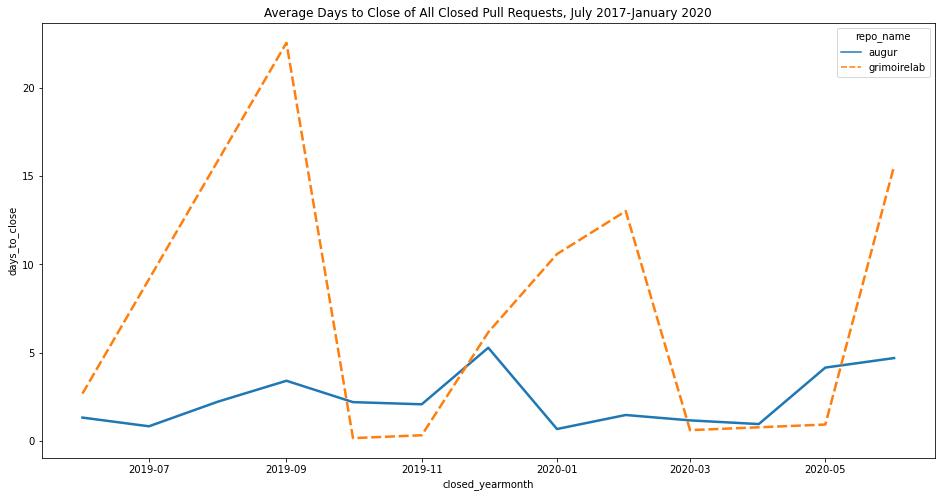

In [19]:
visualize_mean_days_to_close(pr_closed, description='All Closed', save_file=False)

### Average Commits Per PR by Year

In [20]:
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.transform import factor_cmap

def vertical_grouped_bar(input_df, repo_id, group_by = 'merged_flag', x_axis='closed_year', y_axis='num_commits', description='All', title="{}Average Commit Counts Per Year for {} Pull Requests"):
    
    if type(repo_id) == type(repo_list):
        repo_ids = repo_id
    else:
        repo_ids = repo_id

    for repo_id in repo_ids:
    
        output_notebook() # let bokeh display plot in jupyter cell output

        driver_df = input_df.copy() # deep copy input data so we do not change the external dataframe 

        # Filter df by passed *repo_id* param
        driver_df = driver_df.loc[driver_df['repo_id'] == repo_id]

        # Change closed year to int so that doesn't display as 2019.0 for example
        driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)
        
        driver_df = driver_df.reset_index()
        

        # contains the closed years
        x_groups = sorted(list(driver_df[x_axis].unique()))

        # inner groups on x_axis they are merged and not_merged
        groups = list(driver_df[group_by].unique())

        # setup color pallete
        try:
            colors = mpl['Plasma'][len(groups)]
        except:
            colors = [mpl['Plasma'][3][0]] + [mpl['Plasma'][3][1]]

        merged_avg_values = list(driver_df.loc[driver_df[group_by] == 'Merged / Accepted'].groupby([x_axis],as_index=False).mean().round(1)['commit_count'])
        not_merged_avg_values = list(driver_df.loc[driver_df[group_by] == 'Not Merged / Rejected'].groupby([x_axis],as_index=False).mean().round(1)['commit_count'])

        # Setup data in format for grouped bar chart
        data = {
                'years'                   : x_groups,
                'Merged / Accepted'       : merged_avg_values,
                'Not Merged / Rejected'   : not_merged_avg_values,
            }

        x = [ (year, pr_state) for year in x_groups for pr_state in groups ]
        counts = sum(zip(data['Merged / Accepted'], data['Not Merged / Rejected']), ())

        source = ColumnDataSource(data=dict(x=x, counts=counts))

        title_beginning = '{}: '.format(repo_dict[repo_id].capitalize())
        title=title.format(title_beginning, description)
        
        
        plot_width = len(x_groups) * 300
        title_text_font_size = 16 
        
        if (len(title) * title_text_font_size / 2) > plot_width:
            plot_width = int(len(title) * title_text_font_size / 2) + 40
        
        p = figure(x_range=FactorRange(*x), plot_height=450, plot_width=plot_width, title=title, y_range=(0, max(merged_avg_values + not_merged_avg_values)*1.15), toolbar_location=None)

        # Vertical bar glyph
        p.vbar(x='x', top='counts', width=0.9, source=source, line_color="white",
               fill_color=factor_cmap('x', palette=colors, factors=groups, start=1, end=2))

        # Data label 
        labels = LabelSet(x='x', y='counts', text='counts',# y_offset=-8, x_offset=34,
                  text_font_size="12pt", text_color="black",
                  source=source, text_align='center')
        p.add_layout(labels)

        p.y_range.start = 0
        p.x_range.range_padding = 0.1
        p.xaxis.major_label_orientation = 1
        p.xgrid.grid_line_color = None

        p.yaxis.axis_label = 'Average Commits / Pull Request'
        p.xaxis.axis_label = 'Year Closed'

        p.title.align = "center"
        p.title.text_font_size = "{}px".format(title_text_font_size)

        p.xaxis.axis_label_text_font_size = "16px"
        p.xaxis.major_label_text_font_size = "15px"

        p.yaxis.axis_label_text_font_size = "15px"
        p.yaxis.major_label_text_font_size = "15px"
        
        plot = p

        p = figure(width = plot_width, height=200, margin = (0, 0, 0, 0))
        caption = "This graph shows the average commits per pull requests over an entire year, for merged and not merged pull requests."
        p.add_layout(Label(
        x = 0, # Change to shift caption left or right
        y = 160, 
        x_units = 'screen',
        y_units = 'screen',
        text='{}'.format(caption),
        text_font = 'times', # Use same font as paper
        text_font_size = '15pt',
        render_mode='css'
        ))
        p.outline_line_color = None

        caption_plot = p

        grid = gridplot([[plot], [caption_plot]])
        
        show(grid)


        #show(p)

        if save_files:
            export_png(grid, filename="./images/v_grouped_bar/v_grouped_bar__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_dict[repo_id]))


In [21]:
vertical_grouped_bar(pr_all, repo_id=repo_set)

Loading BokehJS ...

Loading BokehJS ...

### Mean Comments for Closed Pull Requests

In [22]:
def horizontal_stacked_bar(input_df, repo_id, group_by='merged_flag', x_axis='comment_count', description="All Closed", y_axis='closed_year', title="Mean Comments for {} Pull Requests"):
    
    if type(repo_id) == type(repo_list):
        repo_ids = repo_id
    else:
        repo_ids = [repo_id]
    
    for repo_id in repo_ids:
    
        driver_df = input_df.copy()

        driver_df = driver_df.loc[driver_df['repo_id'] == repo_id]

        output_notebook()

        try:
            y_groups = sorted(list(driver_df[y_axis].unique()))
        except:
            y_groups = [repo_id]

        groups = driver_df[group_by].unique()
        try:
            colors = mpl['Plasma'][len(groups)]
        except:
            colors = [mpl['Plasma'][3][0]] + [mpl['Plasma'][3][1]]

        len_not_merged = len(driver_df.loc[driver_df['merged_flag'] == 'Not Merged / Rejected'])
        len_merged = len(driver_df.loc[driver_df['merged_flag'] == 'Merged / Accepted'])

        title_beginning = '{}: '.format(repo_dict[repo_id].capitalize()) 
        plot_width = 650
        p = figure(y_range=y_groups, plot_height=450, plot_width=plot_width, # y_range=y_groups,#(pr_all[y_axis].min(),pr_all[y_axis].max()) #y_axis_type="datetime",
                   title='{} {}'.format(title_beginning, title.format(description)), toolbar_location=None)

        possible_maximums= []
        for y_value in y_groups:

            y_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Merged / Accepted')]
            y_not_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Not Merged / Rejected')]

            if len(y_merged_data) > 0:
                y_merged_data[x_axis + '_mean'] = y_merged_data[x_axis].mean().round(1)
            else:
                y_merged_data[x_axis + '_mean'] = 0.00

            if len(y_not_merged_data) > 0:
                y_not_merged_data[x_axis + '_mean'] = y_not_merged_data[x_axis].mean().round(1)
            else:
                y_not_merged_data[x_axis + '_mean'] = 0

            not_merged_source = ColumnDataSource(y_not_merged_data)
            merged_source = ColumnDataSource(y_merged_data)

            possible_maximums.append(max(y_not_merged_data[x_axis + '_mean']))
            possible_maximums.append(max(y_merged_data[x_axis + '_mean']))

            # mean comment count for merged
            merged_comment_count_glyph = p.hbar(y=dodge(y_axis, -0.1, range=p.y_range), left=0, right=x_axis + '_mean', height=0.04*len(driver_df[y_axis].unique()), 
                                         source=merged_source, fill_color="black")#,legend_label="Mean Days to Close",
            # Data label 
            labels = LabelSet(x=x_axis + '_mean', y=dodge(y_axis, -0.1, range=p.y_range), text=x_axis + '_mean', y_offset=-8, x_offset=34,
                      text_font_size="12pt", text_color="black",
                      source=merged_source, text_align='center')
            p.add_layout(labels)
            # mean comment count For nonmerged
            not_merged_comment_count_glyph = p.hbar(y=dodge(y_axis, 0.1, range=p.y_range), left=0, right=x_axis + '_mean', 
                                         height=0.04*len(driver_df[y_axis].unique()), source=not_merged_source, fill_color="#e84d60")#legend_label="Mean Days to Close",
            # Data label 
            labels = LabelSet(x=x_axis + '_mean', y=dodge(y_axis, 0.1, range=p.y_range), text=x_axis + '_mean', y_offset=-8, x_offset=34,
                      text_font_size="12pt", text_color="#e84d60",
                      source=not_merged_source, text_align='center')
            p.add_layout(labels)

    #         p.y_range.range_padding = 0.1
        p.ygrid.grid_line_color = None
        p.legend.location = "bottom_right"
        p.axis.minor_tick_line_color = None
        p.outline_line_color = None
        p.xaxis.axis_label = 'Average Comments / Pull Request'
        p.yaxis.axis_label = 'Repository' if y_axis == 'repo_name' else 'Year Closed' if y_axis == 'closed_year' else ''

        legend = Legend(
                items=[
                    ("Merged Pull Request Mean Comment Count", [merged_comment_count_glyph]),
                    ("Rejected Pull Request Mean Comment Count", [not_merged_comment_count_glyph])
                ],

                location='center', 
                orientation='vertical',
                border_line_color="black"
            )
        p.add_layout(legend, "below")

        p.title.text_font_size = "16px"
        p.title.align = "center"

        p.xaxis.axis_label_text_font_size = "16px"
        p.xaxis.major_label_text_font_size = "16px"

        p.yaxis.axis_label_text_font_size = "16px"
        p.yaxis.major_label_text_font_size = "16px"

        p.x_range = Range1d(0, max(possible_maximums)*1.15)
        
        plot = p
        
        p = figure(width = plot_width, height=200, margin = (0, 0, 0, 0))
        caption = "This graph shows the average number of comments per merged or not merged pull request."
        p.add_layout(Label(
        x = 0, # Change to shift caption left or right
        y = 160, 
        x_units = 'screen',
        y_units = 'screen',
        text='{}'.format(caption),
        text_font = 'times', # Use same font as paper
        text_font_size = '15pt',
        render_mode='css'
        ))
        p.outline_line_color = None

        caption_plot = p

        grid = gridplot([[plot], [caption_plot]])

        show(grid)

        #show(p, plot_width=1200, plot_height=300*len(y_groups) + 300)

        if save_files:
            repo_extension = 'All' if not repo_name else repo_name
            export_png(grid, filename="./images/h_stacked_bar_mean_comments_merged_status/mean_comments_merged_status__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_dict[repo_id]))
        

In [23]:
horizontal_stacked_bar(pr_closed, repo_id=repo_set)

Loading BokehJS ...

Loading BokehJS ...

ValueError: max() arg is an empty sequence

### Count Pull Requests by Merge Status

In [24]:
def merged_ratio_vertical_grouped_bar(data_dict, repo_id, x_axis='closed_year', description="All Closed", title="Count of {} Pull Requests by Merged Status"):
    
    if type(repo_id) == type(repo_list):
        repo_ids = repo_id
    else:
        repo_ids = [repo_id]
    
    for repo_id in repo_ids:
        
        output_notebook()

        colors = mpl['Plasma'][6]

        #if repo_name == 'mbed-os':
            #colors = colors[::-1]

        for data_desc, input_df in data_dict.items():
            x_groups = sorted(list(input_df[x_axis].astype(str).unique()))
            break

        plot_width = 315 * len(x_groups)
        title_beginning = repo_dict[repo_id].capitalize() 
        p = figure(x_range=x_groups, plot_height=350, plot_width=plot_width,  
                   title='{}: {}'.format(title_beginning, title.format(description)), toolbar_location=None)

        dodge_amount = 0.12
        color_index = 0
        x_offset = 50

        all_totals = []
        for data_desc, input_df in data_dict.items():
            driver_df = input_df.copy()

            driver_df[x_axis] = driver_df[x_axis].astype(str)

            groups = sorted(list(driver_df['merged_flag'].unique()))

            driver_df = driver_df.loc[driver_df['repo_id'] == repo_id]

            len_merged = []
            zeros = []
            len_not_merged = []
            totals = []

            for x_group in x_groups:

                len_merged_entry = len(driver_df.loc[(driver_df['merged_flag'] == 'Merged / Accepted') & (driver_df[x_axis] == x_group)])
                totals += [len(driver_df.loc[(driver_df['merged_flag'] == 'Not Merged / Rejected') & (driver_df[x_axis] == x_group)]) + len_merged_entry]
                len_not_merged += [len(driver_df.loc[(driver_df['merged_flag'] == 'Not Merged / Rejected') & (driver_df[x_axis] == x_group)])]
                len_merged += [len_merged_entry]
                zeros.append(0)

            data = {'X': x_groups}
            for group in groups:
                data[group] = []
                for x_group in x_groups:
                    data[group] += [len(driver_df.loc[(driver_df['merged_flag'] == group) & (driver_df[x_axis] == x_group)])]

            data['len_merged'] = len_merged
            data['len_not_merged'] = len_not_merged
            data['totals'] = totals
            data['zeros'] = zeros

            if data_desc == "All":
                all_totals = totals

            source = ColumnDataSource(data)

            stacked_bar = p.vbar_stack(groups, x=dodge('X', dodge_amount, range=p.x_range), width=0.2, source=source, color=colors[1:3], legend_label=[f"{data_desc} " + "%s" % x for x in groups])
            # Data label for merged

            p.add_layout(
                LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='zeros', text='len_merged', y_offset=2, x_offset=x_offset,
                      text_font_size="12pt", text_color=colors[1:3][0],
                      source=source, text_align='center')
            )
            if min(data['totals']) < 400:
                y_offset = 15
            else:
                y_offset = 0
            # Data label for not merged
            p.add_layout(
                LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='totals', text='len_not_merged', y_offset=y_offset, x_offset=x_offset,
                      text_font_size="12pt", text_color=colors[1:3][1],
                      source=source, text_align='center')
            )
            # Data label for total
            p.add_layout(
                LabelSet(x=dodge('X', dodge_amount, range=p.x_range), y='totals', text='totals', y_offset=0, x_offset=0,
                      text_font_size="12pt", text_color='black',
                      source=source, text_align='center')
            )
            dodge_amount *= -1
            colors = colors[::-1]
            x_offset *= -1

        p.y_range = Range1d(0,  max(all_totals)*1.4)

        p.xgrid.grid_line_color = None
        p.legend.location = "top_center"
        p.legend.orientation="horizontal"
        p.axis.minor_tick_line_color = None
        p.outline_line_color = None
        p.yaxis.axis_label = 'Count of Pull Requests'
        p.xaxis.axis_label = 'Repository' if x_axis == 'repo_name' else 'Year Closed' if x_axis == 'closed_year' else ''

        p.title.align = "center"
        p.title.text_font_size = "16px"

        p.xaxis.axis_label_text_font_size = "16px"
        p.xaxis.major_label_text_font_size = "16px"

        p.yaxis.axis_label_text_font_size = "16px"
        p.yaxis.major_label_text_font_size = "16px"

        p.outline_line_color = None
        
        plot = p
        
        p = figure(width = plot_width, height=200, margin = (0, 0, 0, 0))
        caption = "This graph shows the number of closed pull requests per year in four different categories. These four categories are All Merged, All Not Merged, Slowest 20% Merged, and Slowest 20% Not Merged."
        p.add_layout(Label(
        x = 0, # Change to shift caption left or right
        y = 160, 
        x_units = 'screen',
        y_units = 'screen',
        text='{}'.format(caption),
        text_font = 'times', # Use same font as paper
        text_font_size = '15pt',
        render_mode='css'
        ))
        p.outline_line_color = None

        caption_plot = p

        grid = gridplot([[plot], [caption_plot]])

        show(grid)
        
        if save_files:
            repo_extension = 'All' if not repo_id else repo_id
            export_png(grid, filename="./images/v_stacked_bar_merged_status_count/stacked_bar_merged_status_count__{}_PRs__xaxis_{}__repo_{}.png".format(description, x_axis, repo_dict[repo_id]))


In [25]:
for repo_name in pr_all['repo_name'].unique():
    merged_ratio_vertical_grouped_bar({'All':pr_closed,'Slowest 20%':pr_slow20_not_merged.append(pr_slow20_merged,ignore_index=True)}, repo_id = repo_list)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

### Mean Response Time for all Closed Pull Requests

In [26]:
def visualize_mean_response_times(input_df, repo_id, time_unit='days', x_max=95,  y_axis='closed_year', description="All Closed", legend_position=(410, 10)):
    
    if type(repo_id) == type(repo_list):
        repo_ids = repo_id
    else:
        repo_ids = [repo_id]
    
    for repo_id in repo_ids:

        output_notebook() # let bokeh show plot in jupyter cell output

        driver_df = input_df.copy()[['repo_name', 'repo_id', 'merged_flag', y_axis, time_unit + '_to_first_response', time_unit + '_to_last_response', 
                                     time_unit + '_to_close']] # deep copy input data so we do not alter the external dataframe

        # filter by repo_id param
        driver_df = driver_df.loc[driver_df['repo_id'] == repo_id]

        title_beginning = '{}: '.format(repo_dict[repo_id].capitalize())
        plot_width = 950
        p = figure(toolbar_location=None, y_range=sorted(driver_df[y_axis].unique()), plot_width=plot_width, 
                   plot_height=450,#75*len(driver_df[y_axis].unique()),
                   title="{}Mean Response Times for Pull Requests {}".format(title_beginning, description))

        first_response_glyphs = []
        last_response_glyphs = []
        merged_days_to_close_glyphs = []
        not_merged_days_to_close_glyphs = []

        possible_maximums = []
        
        
        
        
        for y_value in driver_df[y_axis].unique():

            y_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Merged / Accepted')]
            y_not_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Not Merged / Rejected')]

            y_merged_data[time_unit + '_to_first_response_mean'] = y_merged_data[time_unit + '_to_first_response'].mean().round(1) if len(y_merged_data) > 0 else 0.00
            y_merged_data[time_unit + '_to_last_response_mean'] = y_merged_data[time_unit + '_to_last_response'].mean().round(1) if len(y_merged_data) > 0 else 0.00
            y_merged_data[time_unit + '_to_close_mean'] = y_merged_data[time_unit + '_to_close'].mean().round(1) if len(y_merged_data) > 0 else 0.00

            y_not_merged_data[time_unit + '_to_first_response_mean'] = y_not_merged_data[time_unit + '_to_first_response'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00
            y_not_merged_data[time_unit + '_to_last_response_mean'] = y_not_merged_data[time_unit + '_to_last_response'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00
            y_not_merged_data[time_unit + '_to_close_mean'] = y_not_merged_data[time_unit + '_to_close'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00

            possible_maximums.append(max(y_merged_data[time_unit + '_to_close_mean']))
            possible_maximums.append(max(y_not_merged_data[time_unit + '_to_close_mean']))
            
            maximum = max(possible_maximums)*1.15
            ideal_difference = maximum*0.064
            
        for y_value in driver_df[y_axis].unique():

            y_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Merged / Accepted')]
            y_not_merged_data = driver_df.loc[(driver_df[y_axis] == y_value) & (driver_df['merged_flag'] == 'Not Merged / Rejected')]

            y_merged_data[time_unit + '_to_first_response_mean'] = y_merged_data[time_unit + '_to_first_response'].mean().round(1) if len(y_merged_data) > 0 else 0.00
            y_merged_data[time_unit + '_to_last_response_mean'] = y_merged_data[time_unit + '_to_last_response'].mean().round(1) if len(y_merged_data) > 0 else 0.00
            y_merged_data[time_unit + '_to_close_mean'] = y_merged_data[time_unit + '_to_close'].mean().round(1) if len(y_merged_data) > 0 else 0.00

            y_not_merged_data[time_unit + '_to_first_response_mean'] = y_not_merged_data[time_unit + '_to_first_response'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00
            y_not_merged_data[time_unit + '_to_last_response_mean'] = y_not_merged_data[time_unit + '_to_last_response'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00
            y_not_merged_data[time_unit + '_to_close_mean'] = y_not_merged_data[time_unit + '_to_close'].mean().round(1) if len(y_not_merged_data) > 0 else 0.00

            not_merged_source = ColumnDataSource(y_not_merged_data)
            merged_source = ColumnDataSource(y_merged_data)

            # mean PR length for merged
            merged_days_to_close_glyph = p.hbar(y=dodge(y_axis, -0.1, range=p.y_range), left=0, right=time_unit + '_to_close_mean', height=0.04*len(driver_df[y_axis].unique()), 
                                         source=merged_source, fill_color="black")#,legend_label="Mean Days to Close",
            merged_days_to_close_glyphs.append(merged_days_to_close_glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_close_mean', y=dodge(y_axis, -0.1, range=p.y_range), text=time_unit + '_to_close_mean', y_offset=-8, x_offset=34, #34
                      text_font_size="12pt", text_color="black",
                      source=merged_source, text_align='center')
            p.add_layout(labels)


            # mean PR length For nonmerged
            not_merged_days_to_close_glyph = p.hbar(y=dodge(y_axis, 0.1, range=p.y_range), left=0, right=time_unit + '_to_close_mean', 
                                         height=0.04*len(driver_df[y_axis].unique()), source=not_merged_source, fill_color="#e84d60")#legend_label="Mean Days to Close",
            not_merged_days_to_close_glyphs.append(not_merged_days_to_close_glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_close_mean', y=dodge(y_axis, 0.1, range=p.y_range), text=time_unit + '_to_close_mean', y_offset=-8, x_offset=44,
                      text_font_size="12pt", text_color="#e84d60",
                      source=not_merged_source, text_align='center')
            p.add_layout(labels)

            
            #if the difference between two values is less than 6.4 percent move the second one to the right 30 pixels
            if (max(y_merged_data[time_unit + '_to_last_response_mean']) - max(y_merged_data[time_unit + '_to_first_response_mean'])) < ideal_difference:
                merged_x_offset = 30
            else:
                merged_x_offset = 0
                
            #if the difference between two values is less than 6.4 percent move the second one to the right 30 pixels
            if (max(y_not_merged_data[time_unit + '_to_last_response_mean']) - max(y_not_merged_data[time_unit + '_to_first_response_mean'])) < ideal_difference:
                not_merged_x_offset = 30
            else:
                not_merged_x_offset = 0
                
            #if there is only one bar set the y_offsets so the labels will not overlap the bars
            if len(driver_df[y_axis].unique()) == 1:
                merged_y_offset = -65
                not_merged_y_offset = 45
            else:
                merged_y_offset = -45
                not_merged_y_offset = 25
            
            
            # mean time to first response
            glyph = Rect(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, -0.1, range=p.y_range), width=x_max/100, height=0.08*len(driver_df[y_axis].unique()), fill_color=colors[0])
            first_response_glyph = p.add_glyph(merged_source, glyph)
            first_response_glyphs.append(first_response_glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0, range=p.y_range),text=time_unit + '_to_first_response_mean',x_offset = 0, y_offset=merged_y_offset,#-60,
                      text_font_size="12pt", text_color=colors[0],
                      source=merged_source, text_align='center')
            p.add_layout(labels)

            #for nonmerged
            glyph = Rect(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0.1, range=p.y_range), width=x_max/100, height=0.08*len(driver_df[y_axis].unique()), fill_color=colors[0])
            first_response_glyph = p.add_glyph(not_merged_source, glyph)
            first_response_glyphs.append(first_response_glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_first_response_mean', y=dodge(y_axis, 0, range=p.y_range),text=time_unit + '_to_first_response_mean',x_offset = 0, y_offset=not_merged_y_offset,#40,
                              text_font_size="12pt", text_color=colors[0],
                      source=not_merged_source, text_align='center')
            p.add_layout(labels)


            # mean time to last response
            glyph = Rect(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, -0.1, range=p.y_range), width=x_max/100, height=0.08*len(driver_df[y_axis].unique()), fill_color=colors[1])
            last_response_glyph = p.add_glyph(merged_source, glyph)
            last_response_glyphs.append(last_response_glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0, range=p.y_range), text=time_unit + '_to_last_response_mean', x_offset=merged_x_offset, y_offset=merged_y_offset,#-60,
                      text_font_size="12pt", text_color=colors[1],
                      source=merged_source, text_align='center')
            p.add_layout(labels)
            

            #for nonmerged
            glyph = Rect(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0.1, range=p.y_range), width=x_max/100, height=0.08*len(driver_df[y_axis].unique()), fill_color=colors[1])
            last_response_glyph = p.add_glyph(not_merged_source, glyph)
            last_response_glyphs.append(last_response_glyph)
            # Data label 
            labels = LabelSet(x=time_unit + '_to_last_response_mean', y=dodge(y_axis, 0, range=p.y_range), text=time_unit + '_to_last_response_mean', x_offset = not_merged_x_offset, y_offset=not_merged_y_offset,#40,
                      text_font_size="12pt", text_color=colors[1],
                      source=not_merged_source, text_align='center')
            p.add_layout(labels)

        p.title.align = "center"
        p.title.text_font_size = "16px"

        p.xaxis.axis_label = "Days to Close"
        p.xaxis.axis_label_text_font_size = "16px"
        p.xaxis.major_label_text_font_size = "16px"
        
        #adjust the starting point and ending point based on the maximum of maximum of the graph
        p.x_range = Range1d(maximum/30 * -1, maximum*1.15)

        p.yaxis.axis_label = "Repository" if y_axis == 'repo_name' else 'Year Closed' if y_axis == 'closed_year' else ''
        p.yaxis.axis_label_text_font_size = "16px"
        p.yaxis.major_label_text_font_size = "16px"
        p.ygrid.grid_line_color = None
        p.y_range.range_padding = 0.15

        p.outline_line_color = None
        p.toolbar.logo = None
        p.toolbar_location = None

        def add_legend(location, orientation, side):
            legend = Legend(
                items=[
                    ("Mean Days to First Response", first_response_glyphs),
                    ("Mean Days to Last Response", last_response_glyphs),
                    ("Merged Mean Days to Close", merged_days_to_close_glyphs),
                    ("Not Merged Mean Days to Close", not_merged_days_to_close_glyphs)
                ],

                location=location, 
                orientation=orientation,
                border_line_color="black"
        #         title='Example Title'
            )
            p.add_layout(legend, side)

    #     add_legend((150, 50), "horizontal", "center")
        add_legend(legend_position, "vertical", "right")
        
        plot = p
        
        p = figure(width = plot_width, height = 200, margin = (0, 0, 0, 0))
        caption = "Caption Here"
        p.add_layout(Label(
        x = 0, # Change to shift caption left or right
        y = 160, 
        x_units = 'screen',
        y_units = 'screen',
        text='{}'.format(caption),
        text_font = 'times', # Use same font as paper
        text_font_size = '15pt',
        render_mode='css'
        ))
        p.outline_line_color = None

        caption_plot = p

        grid = gridplot([[plot], [caption_plot]])

        show(grid)

        if save_files:
            export_png(grid, filename="./images/hbar_response_times/mean_response_times__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_dict[repo_id]))

In [27]:
for repo_name in pr_closed['repo_name'].unique():
    visualize_mean_response_times(pr_closed, repo_id=repo_list, legend_position='center')

Loading BokehJS ...

Loading BokehJS ...

ValueError: max() arg is an empty sequence

### Mean Days Between Comments for Pull Requests

In [28]:
def visualize_mean_time_between_responses(data_dict, repo_id, time_unit='Days', x_axis='closed_yearmonth', description="All Closed", line_group='merged_flag', y_axis='average_days_between_responses', num_outliers_repo_map={}):
    
    if type(repo_id) == type(repo_list):
        repo_ids = repo_id
    else:
        repo_ids = [repo_id]
    
    for repo_id in repo_ids:
    
        output_notebook()
        plot_width = 950
        p1 = figure(x_axis_type="datetime", title="{}: Mean {} Between Comments by Month Closed for {} Pull Requests".format(repo_dict[repo_id].capitalize(), time_unit, description), plot_width=plot_width, x_range=(pr_all[x_axis].min(),pr_all[x_axis].max()), plot_height=500, toolbar_location=None)
        colors = Category20[10][6:]
        color_index = 0

        glyphs = []

        possible_maximums = []
        for data_desc, input_df in data_dict.items():

            driver_df = input_df.copy()

            driver_df = remove_outliers(driver_df, y_axis, num_outliers_repo_map)

            driver_df = driver_df.loc[driver_df['repo_id'] == repo_id]
            index = 0

            driver_df_mean = driver_df.groupby(['repo_id', line_group, x_axis],as_index=False).mean()

            title_ending = ''
            if repo_id:
                title_ending += ' for Repo: {}'.format(repo_id)

            for group_num, line_group_value in enumerate(driver_df[line_group].unique(), color_index):
                glyphs.append(p1.line(driver_df_mean.loc[driver_df_mean[line_group] == line_group_value][x_axis], driver_df_mean.loc[driver_df_mean[line_group] == line_group_value][y_axis], color=colors[group_num], line_width = 3))
                color_index += 1
                possible_maximums.append(max(driver_df_mean.loc[driver_df_mean[line_group] == line_group_value][y_axis].dropna()))
        for repo, num_outliers in num_outliers_repo_map.items():
            if repo_name == repo:
                p1.add_layout(Title(text="** {} outliers for {} were removed".format(num_outliers, repo), align="center"), "below")

        p1.grid.grid_line_alpha = 0.3
        p1.xaxis.axis_label = 'Month Closed'
        p1.xaxis.ticker.desired_num_ticks = 15
        p1.yaxis.axis_label = 'Mean {} Between Responses'.format(time_unit)
        p1.legend.location = "top_left"

        legend = Legend(
            items=[
                ("All Not Merged / Rejected", [glyphs[0]]),
                ("All Merged / Accepted", [glyphs[1]]),
                ("Slowest 20% Not Merged / Rejected", [glyphs[2]]),
                ("Slowest 20% Merged / Accepted", [glyphs[3]])
            ],

            location='center_right', 
            orientation='vertical',
            border_line_color="black"
        )

        p1.add_layout(legend, 'right')

        p1.title.text_font_size = "16px"

        p1.xaxis.axis_label_text_font_size = "16px"
        p1.xaxis.major_label_text_font_size = "16px"

        p1.yaxis.axis_label_text_font_size = "16px"
        p1.yaxis.major_label_text_font_size = "16px"
        p1.xaxis.major_label_orientation = 45.0
        
        p1.y_range = Range1d(0,  max(possible_maximums)*1.15)
        
        plot = p1
        
        p = figure(width = plot_width, height=200, margin = (0, 0, 0, 0))
        caption = "This graph shows the average number of days between comments for all closed pull requests per month in four categories. These four categories are All Merged, All Not Merged, Slowest 20% Merged, and Slowest 20% Not Merged."
        p.add_layout(Label(
        x = 0, # Change to shift caption left or right
        y = 160, 
        x_units = 'screen',
        y_units = 'screen',
        text='{}'.format(caption),
        text_font = 'times', # Use same font as paper
        text_font_size = '15pt',
        render_mode='css'
        ))
        p.outline_line_color = None

        caption_plot = p

        grid = gridplot([[plot], [caption_plot]])

        show(grid)

        if save_files:
            repo_extension = 'All' if not repo_name else repo_name
            export_png(grid, filename="./images/line_mean_time_between_comments/line_mean_time_between_comments__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_dict[repo_id]))

In [29]:
for repo_name in pr_all['repo_name'].unique():
    visualize_mean_time_between_responses({'All':pr_closed,'Slowest 20%':pr_slow20_not_merged.append(pr_slow20_merged,ignore_index=True)}, repo_id = repo_list)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

### Days to First Respose to Pull requests

In [30]:
def visualize_time_to_first_comment(input_df, repo_id, x_axis='pr_closed_at', y_axis='days_to_first_response', description='All', num_outliers_repo_map={}, group_by='merged_flag', same_scales=True, columns=2, legend_position='top_right', remove_outliers = 0):
    if type(repo_id) == type(repo_list):
        repo_ids = repo_id
    else:
        repo_ids = [repo_id]
    
    for repo_id in repo_ids:
    
        output_notebook()

        driver_df = input_df.copy()

        driver_df = driver_df.loc[driver_df['repo_id'] == repo_id]

        group_by_groups = sorted(driver_df[group_by].unique())

        seconds = ((driver_df[x_axis].max() + datetime.timedelta(days=25))- (driver_df[x_axis].min() - datetime.timedelta(days=30))).total_seconds()
        quarter_years = seconds / 10506240
        quarter_years = round(quarter_years)

        title_beginning = '{}: '.format(repo_dict[repo_id].capitalize()) 
        plot_width = 180 * 5
        p = figure(x_range=(driver_df[x_axis].min() - datetime.timedelta(days=30), driver_df[x_axis].max() + datetime.timedelta(days=25)), 
                  #(driver_df[y_axis].min(), driver_df[y_axis].max()), 
                   toolbar_location=None,
                   title='{}Days to First Response for {} Closed Pull Requests'.format(title_beginning, description), plot_width=plot_width, 
                   plot_height=400, x_axis_type='datetime')

        for index, group_by_group in enumerate(group_by_groups):
            p.scatter(x_axis, y_axis, color=colors[index], marker="square", source=driver_df.loc[driver_df[group_by] == group_by_group], legend_label=group_by_group)

            if group_by_group == "Merged / Accepted":
                merged_values = driver_df.loc[driver_df[group_by] == group_by_group][y_axis].dropna().values.tolist()
            else:
                not_merged_values = driver_df.loc[driver_df[group_by] == group_by_group][y_axis].dropna().values.tolist()

        values = not_merged_values + merged_values
        #values.fillna(0)

        for value in range(0, remove_outliers):
            values.remove(max(values))
 
        #determine y_max by finding the max of the values and scaling it up a small amoutn
        y_max = max(values)*1.0111
        outliers = driver_df.loc[driver_df[y_axis] > y_max]
        if len(outliers) > 0:
            if repo_id:
                p.add_layout(Title(text="** Outliers cut off at {} days: {} outlier(s) for {} were removed **".format(y_max, len(outliers), repo_name), align="center"), "below")
            else:
                p.add_layout(Title(text="** Outliers cut off at {} days: {} outlier(s) were removed **".format(y_max, len(outliers)), align="center"), "below")

        p.xaxis.axis_label = 'Date Closed' if x_axis == 'pr_closed_at' else 'Date Created' if x_axis == 'pr_created_at' else 'Date'
        p.yaxis.axis_label = 'Days to First Response'
        p.legend.location = legend_position

        p.title.align = "center"
        p.title.text_font_size = "16px"

        p.xaxis.axis_label_text_font_size = "16px"
        p.xaxis.major_label_text_font_size = "16px"

        p.yaxis.axis_label_text_font_size = "16px"
        p.yaxis.major_label_text_font_size = "16px"

        p.y_range = Range1d(0, y_max)
        
        plot = p
        
        p = figure(width = plot_width, height=200, margin = (0, 0, 0, 0))
        caption = "This graph shows the days to first reponse for individual pull requests, either Merged or Not Merged."
        p.add_layout(Label(
        x = 0, # Change to shift caption left or right
        y = 160, 
        x_units = 'screen',
        y_units = 'screen',
        text='{}'.format(caption),
        text_font = 'times', # Use same font as paper
        text_font_size = '15pt',
        render_mode='css'
        ))
        p.outline_line_color = None

        caption_plot = p

        grid = gridplot([[plot], [caption_plot]])

        show(grid)

        if save_files:
            repo_extension = repo_ids
            export_png(grid, filename="./images/first_comment_times/scatter_first_comment_times__{}_PRs__xaxis_{}__repo_{}.png".format(description, x_axis, repo_dict[repo_id]))

In [31]:
for repo_name in pr_all['repo_name'].unique():
    visualize_time_to_first_comment(pr_closed, repo_id= repo_list, legend_position='top_right', remove_outliers = scatter_plot_outliers_removed)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [32]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
    colors in RGB and hex form for use in a graphing function
    defined later on '''
    return {"hex":[RGB_to_hex(RGB) for RGB in gradient],
      "r":[RGB[0] for RGB in gradient],
      "g":[RGB[1] for RGB in gradient],
      "b":[RGB[2] for RGB in gradient]}

def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
            "{0:x}".format(v) for v in RGB])

def linear_gradient(start_hex, finish_hex="#FFFFFF", n=10):
    ''' returns a gradient list of (n) colors between
    two hex colors. start_hex and finish_hex
    should be the full six-digit color string,
    inlcuding the number sign ("#FFFFFF") '''
    # Starting and ending colors in RGB form
    s = hex_to_RGB(start_hex)
    f = hex_to_RGB(finish_hex)
    # Initilize a list of the output colors with the starting color
    RGB_list = [s]
    # Calcuate a color at each evenly spaced value of t from 1 to n
    for t in range(1, n):
        # Interpolate RGB vector for color at the current value of t
        curr_vector = [
          int(s[j] + (float(t)/(n-1))*(f[j]-s[j]))
          for j in range(3)
        ]
        # Add it to our list of output colors
        RGB_list.append(curr_vector)

    return color_dict(RGB_list)

### Average Pull Request Event Types for Pull Requests

In [33]:
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter, LogTicker, Label
from bokeh.transform import transform
        
def events_types_heat_map(input_df, repo_id, include_comments=True, x_axis='closed_year', facet="merged_flag",columns=2, x_max=1100, same_scales=True, y_axis='repo_name', description="All Closed", title="Average Pull Request Event Types for {} Pull Requests"):
    if type(repo_id) == type(repo_list):
        repo_ids = repo_id
    else:
        repo_ids = [repo_id]
    
    for repo_id in repo_ids:
    
        colors = linear_gradient('#f5f5dc', '#fff44f', 150)['hex']

        driver_df = input_df.copy()
        driver_df[x_axis] = driver_df[x_axis].astype(str)

        driver_df = driver_df.loc[driver_df['repo_id'] == repo_id]

        if facet == 'closed_year' or y_axis == 'closed_year':
            driver_df['closed_year'] = driver_df['closed_year'].astype(int).astype(str)

        optional_comments = ['comment_count'] if include_comments else []
        driver_df = driver_df[['repo_id', 'repo_name',x_axis, 'assigned_count',
              'review_requested_count',
              'labeled_count',
              'subscribed_count',
              'mentioned_count',
              'referenced_count',
              'closed_count',
              'head_ref_force_pushed_count',
              'merged_count',
              'milestoned_count',
              'unlabeled_count',
              'head_ref_deleted_count', facet ] + optional_comments]
        y_groups = [
              'review_requested_count',
              'labeled_count',
              'subscribed_count',
              'referenced_count',
              'closed_count',
    #           'milestoned_count',
              ] + optional_comments
        output_notebook()
        optional_group_comments = ['comment'] if include_comments else []
    #     y_groups = ['subscribed', 'mentioned', 'labeled', 'review_requested', 'head_ref_force_pushed', 'referenced', 'closed', 'merged', 'unlabeled', 'head_ref_deleted', 'milestoned', 'assigned'] + optional_group_comments

        x_groups = sorted(list(driver_df[x_axis].unique()))

        grid_array = []
        grid_row = []  

        for index, facet_group in enumerate(sorted(driver_df[facet].unique())):

            facet_data = driver_df.loc[driver_df[facet] == facet_group]
    #         display(facet_data.sort_values('merged_count', ascending=False).head(50))
            driver_df_mean = facet_data.groupby(['repo_id', 'repo_name', x_axis], as_index=False).mean().round(1)
    #         data = {'Y' : y_groups}
    #         for group in y_groups:
    #             data[group] = driver_df_mean[group].tolist()
            plot_width = 700
            p = figure(y_range=y_groups, plot_height=500, plot_width=plot_width, x_range=x_groups, 
                       title='{}'.format(format(facet_group)))

            for y_group in y_groups:
                driver_df_mean['field'] = y_group
                source = ColumnDataSource(driver_df_mean)
                mapper = LinearColorMapper(palette=colors, low=driver_df_mean[y_group].min(), high=driver_df_mean[y_group].max())

                p.rect(y='field', x=x_axis, width=1, height=1, source=source,
                       line_color=None, fill_color=transform(y_group, mapper))
                # Data label 
                labels = LabelSet(x=x_axis, y='field', text=y_group, y_offset=-8,
                          text_font_size="12pt", text_color='black',
                          source=source, text_align='center')
                p.add_layout(labels)

                color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                                     ticker=BasicTicker(desired_num_ticks=9),
                                     formatter=PrintfTickFormatter(format="%d"))
    #         p.add_layout(color_bar, 'right')


            p.y_range.range_padding = 0.1
            p.ygrid.grid_line_color = None

            p.legend.location = "bottom_right"
            p.axis.minor_tick_line_color = None
            p.outline_line_color = None

            p.xaxis.axis_label = 'Year Closed'
            p.yaxis.axis_label = 'Event Type'

            p.title.align = "center"
            p.title.text_font_size = "15px"

            p.xaxis.axis_label_text_font_size = "16px"
            p.xaxis.major_label_text_font_size = "16px"

            p.yaxis.axis_label_text_font_size = "16px"
            p.yaxis.major_label_text_font_size = "16px"

            grid_row.append(p)
            if index % columns == columns - 1:
                grid_array.append(grid_row)
                grid_row = []
        grid = gridplot(grid_array)
        
        #add title, the title changes its x value based on the number of x_groups so that it stays centered
        label=Label(x=-len(x_groups), y=6.9, text='{}: Average Pull Request Event Types for {} Closed Pull Requests'.format(repo_dict[repo_id].capitalize(), description), render_mode='css', text_font_size = '17px', text_font_style= 'bold')
        p.add_layout(label)

        show(grid, plot_width=1200, plot_height=1200)
        if save_files:
            comments_included = 'comments_included' if include_comments else 'comments_not_included'
            repo_extension = 'All' if not repo_id else repo_id
            export_png(grid, filename="./images/h_stacked_bar_mean_event_types/mean_event_types__facet_{}__{}_PRs__yaxis_{}__{}__repo_{}.png".format(facet, description, y_axis, comments_included, repo_dict[repo_id]))


In [34]:
for repo_name in pr_all['repo_name'].unique():
    events_types_heat_map(pr_closed, repo_id=repo_list)

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

### Heat Map

In [35]:

red_green_gradient = linear_gradient('#0080FF', '#DC143C', 150)['hex']
    #32CD32
def heat_map(input_df, repo_id, x_axis='repo_name', group_by='merged_flag', y_axis='closed_yearmonth', same_scales=True, description="All Closed", heat_field='pr_duration_days', columns=2, remove_outliers = 0):


    output_notebook()

    driver_df = input_df.copy()[['repo_id', y_axis, group_by, x_axis, heat_field]]
    
    print(driver_df)

    if display_grouping == 'repo':
        driver_df = driver_df.loc[driver_df['repo_id'] == repo_id]

    driver_df[y_axis] = driver_df[y_axis].astype(str)

    # add new group by + xaxis column 
    driver_df['grouped_x'] = driver_df[x_axis] + ' - ' + driver_df[group_by]

    driver_df_mean = driver_df.groupby(['grouped_x', y_axis], as_index=False).mean()

    colors = red_green_gradient
    y_groups = driver_df_mean[y_axis].unique()
    x_groups = sorted(driver_df[x_axis].unique())
    grouped_x_groups = sorted(driver_df_mean['grouped_x'].unique())

    values = driver_df_mean['pr_duration_days'].values.tolist()
    for i in range(0, remove_outliers):
        values.remove(max(values))

    heat_max = max(values)* 1.02

    mapper = LinearColorMapper(palette=colors, low=driver_df_mean[heat_field].min(), high=heat_max)#driver_df_mean[heat_field].max())

    source = ColumnDataSource(driver_df_mean)
    title_beginning = repo_dict[repo_id] + ':' if not type(repo_id) == type(repo_list) else ''
    plot_width = 1100
    p = figure(plot_width=plot_width, plot_height=300, title="{} Mean Duration (Days) {} Pull Requests".format(title_beginning,description),
               y_range=grouped_x_groups[::-1], x_range=y_groups,
               toolbar_location=None, tools="")#, x_axis_location="above")

    for x_group in x_groups:
        outliers = driver_df_mean.loc[(driver_df_mean[heat_field] > heat_max) & (driver_df_mean['grouped_x'].str.contains(x_group))]

        if len(outliers) > 0:
            p.add_layout(Title(text="** Outliers capped at {} days: {} outlier(s) for {} were capped at {} **".format(heat_max, len(outliers), x_group, heat_max), align="center"), "below")

    p.rect(x=y_axis, y='grouped_x', width=1, height=1, source=source,
           line_color=None, fill_color=transform(heat_field, mapper))

    color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                         ticker=BasicTicker(desired_num_ticks=9),
                         formatter=PrintfTickFormatter(format="%d"))

    p.add_layout(color_bar, 'right')

    p.title.align = "center"
    p.title.text_font_size = "16px"

    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "11pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = 1.0
    p.xaxis.axis_label = 'Month Closed' if y_axis[0:6] == 'closed' else 'Date Created' if y_axis[0:7] == 'created' else 'Repository' if y_axis == 'repo_name' else ''
#     p.yaxis.axis_label = 'Merged Status'

    p.title.text_font_size = "16px"

    p.xaxis.axis_label_text_font_size = "16px"
    p.xaxis.major_label_text_font_size = "14px"

    p.yaxis.major_label_text_font_size = "15px"

    plot = p

    p = figure(width = plot_width, height=200, margin = (0, 0, 0, 0))
    caption = "Caption Here"
    p.add_layout(Label(
    x = 0, # Change to shift caption left or right
    y = 160, 
    x_units = 'screen',
    y_units = 'screen',
    text='{}'.format(caption),
    text_font = 'times', # Use same font as paper
    text_font_size = '15pt',
    render_mode='css'
    ))
    p.outline_line_color = None

    caption_plot = p

    grid = gridplot([[plot], [caption_plot]])

    show(grid)

    if save_files:
        repo_extension = 'All' if not repo_id else repo_id
        export_png(grid, filename="./images/heat_map_pr_duration_merged_status/heat_map_duration_by_merged_status__{}_PRs__yaxis_{}__repo_{}.png".format(description, y_axis, repo_dict[repo_id]))

In [36]:
heat_map(pr_closed, repo_id=25440)

Loading BokehJS ...

KeyError: "['pr_duration_days'] not in index"

In [ ]:
pr_closed.columns